## 현재날씨 : 지역, 상태, 온도, 체감온도, 습도, 풍향

In [23]:
import requests
from bs4 import BeautifulSoup
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
 
source = requests.get('https://www.weather.go.kr/weather/observation/currentweather.jsp')
soup = BeautifulSoup(source.content,"html.parser")
 
table = soup.find('table',{'class':'table_develop3'})
data = []
 
print("#"*50)

for tr in table.find_all('tr'):
    tds = list(tr.find_all('td'))
    for td in tds:
        if td.find('a'):
            w_local = td.find('a').text
            w_status = tds[1].text
            w_temp = tds[5].text
            w_body_temp = tds[7].text
            w_humidity = tds[10].text
            w_wind = tds[11].text
            print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
            data.append([w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind])
            
print("#"*50)
 
print(data)

##################################################
강릉              -0.3    -3.3    49      서       
강진군             0.9     -1.4    68      북북서     
강화              -5.6    -9.0    87      북       
거제              2.5     0.8     42      서북서     
거창              0.6     -3.0    57      서       
경주시             0.6     -1.2    45      북       
고산              6.2     0.6     68      북북서     
고창              -1.0    -1.0    71      남       
고창군             -0.5    -0.5    69      정온      
고흥              1.5     -1.5    65      서북서     
광양시             1.5     -1.1    54      서       
광주      구름많음    1.3     1.3     71      서       
구미              1.7     -0.2    50      서북서     
군산              -0.4    -2.9    85      남동      
금산              0.2     0.2     66      남서      
김해시             0.7     -1.3    36      서       
남원              0.3     0.3     65      북북서     
남해              2.3     -0.6    49      서북서     
대관령             -7.9    -17.7   74      서북서     
대구      구름조금    1.

In [24]:
with open('weather.csv','w', encoding='utf-8-sig') as f:
    f.write('지역, 상태, 온도, 체감온도, 습도, 풍향\n')
    for i in data:
        f.write('{0},{1},{2},{3},{4},{5}\n'.format(i[0],i[1],i[2],i[3],i[4],i[5]))

In [25]:
df = pandas.read_csv('weather.csv', index_col='지역' , encoding='utf-8-sig')

#### 여기 안 함

In [17]:
city_df = df.loc[['서울','인천','대전','대구','광주','부산','울산']]

print(city_df)

city_df.to_csv('현재날씨.csv',encoding='utf-8-sig')

          상태   온도   체감온도   습도   풍향
지역                                
서울      구름많음 -4.1   -8.2   69   북동
인천        맑음 -4.8   -7.4   71  동남동
대전  약한 눈 단속적 -0.1   -2.8   64   남서
대구      구름조금  1.3   -1.8   48  서북서
광주      구름많음  1.3    1.3   71    서
부산        맑음  1.0    1.0   35   정온
울산        맑음  1.3   -0.7   43   북서


C:\Users\smhrd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\smhrd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


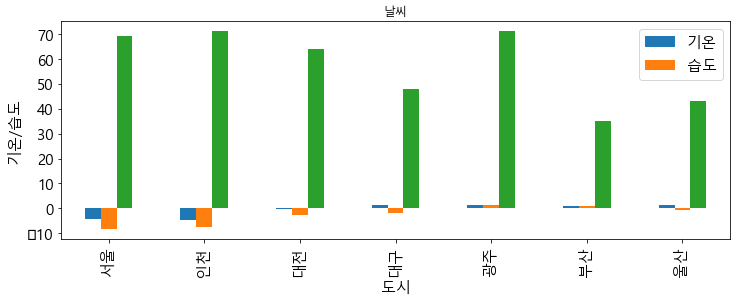

In [18]:
# 그래프
font_name = mpl.font_manager.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
mpl.rc('font',family=font_name)
 
ax = city_df.plot(kind='bar',title='날씨',figsize=(12,4),legend=True,fontsize=15)
ax.set_xlabel('도시',fontsize=15)
ax.set_ylabel('기온/습도',fontsize=15)
ax.legend(['기온','습도'],fontsize=15)
 
plt.show()

#### 여기부터

### DB 연결

In [26]:
!pip install cx_Oracle
import cx_Oracle
from bs4 import BeautifulSoup
import requests as req
from pprint import pprint
!pip install pymssql
import pyodbc

### Oracle DB : data 생성

In [27]:
dsn = cx_Oracle.makedsn('project-db-stu.ddns.net',1524,'xe')
url = "https://www.weather.go.kr/weather/observation/currentweather.jsp"
material = req.get(url)
soup = BeautifulSoup(material.text, 'html.parser')
conn = cx_Oracle.connect('cgi_8_1_1216','smhrd1',dsn)

with conn :
    cur = conn.cursor()
    drop_table = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP TABLE t_live_weather';
                    EXCEPTION
                        WHEN OTHERS THEN
                            IF SQLCODE != -942 THEN
                                RAISE;
                            END IF;
                    END;
                """
    cur.execute(drop_table)
    
    drop_seq = """
                    BEGIN
                        EXECUTE IMMEDIATE 'DROP SEQUENCE fc_seq';
                    EXCEPTION
                        WHEN OTHERS THEN
                        IF SQLCODE != -2289 THEN
                            RAISE;
                        END IF;
                    END;
                """
    cur.execute(drop_seq)
    
    create_table ="""
                    create table t_live_weather(
                        w_index number(4) primary key,
                        w_local varchar2(20),
                        w_status varchar2(20),
                        w_temp number(5),
                        w_body_temp number(5),
                        w_humidity number(5),
                        w_wind varchar2(20)                        
                    )
                """
    cur.execute(create_table)
    
    cur.execute("create sequence fc_seq")
        
    for tr in table.find_all('tr'):
        tds = list(tr.find_all('td'))
        for td in tds:
            if td.find('a'):
                w_local = td.find('a').text
                w_status = tds[1].text
                w_temp = tds[5].text
                w_body_temp = tds[7].text
                w_humidity = tds[10].text
                w_wind = tds[11].text
                print("{0:<7} {1:<7} {2:<7} {3:<7} {4:<7} {5:<7} ".format(w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
                data.append([w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind])
        
        # 데이터 삽입
        insert_data = """
                        insert into t_live_weather(w_index, w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind)
                        values(fc_seq.nextval, :1, :2, :3, :4, :5, :6)
                    """
        cur.execute(insert_data, (w_local, w_status, w_temp, w_body_temp, w_humidity, w_wind))
    conn.commit()

    cur.execute("select * from t_live_weather") #데이터 조회 => 데이터 추가됐는지 확인
    pprint(cur.fetchall())

강릉              -0.3    -3.3    49      서       
강진군             0.9     -1.4    68      북북서     
강화              -5.6    -9.0    87      북       
거제              2.5     0.8     42      서북서     
거창              0.6     -3.0    57      서       
경주시             0.6     -1.2    45      북       
고산              6.2     0.6     68      북북서     
고창              -1.0    -1.0    71      남       
고창군             -0.5    -0.5    69      정온      
고흥              1.5     -1.5    65      서북서     
광양시             1.5     -1.1    54      서       
광주      구름많음    1.3     1.3     71      서       
구미              1.7     -0.2    50      서북서     
군산              -0.4    -2.9    85      남동      
금산              0.2     0.2     66      남서      
김해시             0.7     -1.3    36      서       
남원              0.3     0.3     65      북북서     
남해              2.3     -0.6    49      서북서     
대관령             -7.9    -17.7   74      서북서     
대구      구름조금    1.3     -1.8    48      서북서     
대전      약한 눈 단속적 -0.